# ResNet Learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from PIL import ImageShow

import numpy as np
import matplotlib.pyplot as plt
import tqdm

C:\Users\gurus\anaconda3\envs\Learning_DS_ML_DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(device)

cuda


In [3]:
# function to read CFAR10 dataset
# Obtained from CFAR10 website
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
data_set_info = {
    'base_dir': './cifar-10-batches-py',
    'batch_base_name': 'data_batch_',
}

model_info = {
    'depth':20
}

training_info = {
    'optimizer': 'adam',
    'learning_rate': 0.01,
    'epochs': 100,
}

In [5]:
# Read the meta data file that you get from dataset download

meta_data = unpickle(data_set_info['base_dir'] + '/batches.meta' )

print(meta_data.keys())
print(meta_data[b'num_cases_per_batch'])
print(meta_data[b'label_names'])
print(meta_data[b'num_vis'])

MAX_CFAR10_BATCHES = 5

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
10000
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
3072


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
batch shape =  (10000, 3072)
label shape =  10000


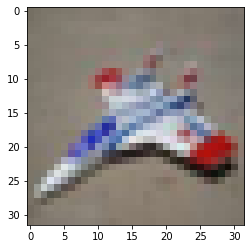

In [6]:
# A look at the dataset
# Each batch contains 10000 images

batch_1 = unpickle(data_set_info['base_dir'] + '/' + data_set_info['batch_base_name'] + str(1))

print(batch_1.keys())
print('batch shape = ', batch_1[b'data'].shape) # 10000 images; 32x32x3 image size
print('label shape = ', len(batch_1[b'labels']) ) # List with 10000 lebels

plt.imshow( np.rot90(np.rot90(np.rot90(batch_1[b'data'][30].reshape((3,32,32)).T))) )

## Create the ResNet network

In [7]:
class BasicResBlock(nn.Module):
    
    def __init__(self, in_channel, downsample):
        super(BasicResBlock, self).__init__()
        
        out_channel = in_channel
        self.downsample = downsample
        self.stride_conv = (1,1)
        self.padding_conv = (1,1)
        
        if self.downsample:
            out_channel = in_channel * 2
            self.stride_conv = (2,2)

        self.conv1 = nn.Conv2d(in_channel, out_channel, (3, 3), stride=self.stride_conv, padding=self.padding_conv)
        self.batch_norm1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channel, out_channel, (3, 3), stride=(1, 1), padding=(1, 1))
        self.batch_norm2 = nn.BatchNorm2d(out_channel)
        self.relu2 = nn.ReLU()
        
        self.conv1x1 = nn.Conv2d(in_channel, out_channel, (1, 1), stride=self.stride_conv, padding=(0, 0))
        self.batch_norm3 = nn.BatchNorm2d(out_channel)
        self.relu3 = nn.ReLU()
        
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.batch_norm1(out1)
        out3 = self.relu1(out2)

        out4 = self.conv2(out3)
        out5 = self.batch_norm2(out4)
        
        if self.downsample:
            #print('1x1 conv applied')
            x = self.conv1x1(x)
            x = self.batch_norm3(x)
            x = self.relu3(x)
            
        #print('x shape = ', x.shape)
        #print('out5 shape = ', out5.shape)
        
        out6 = self.relu2(out5 + x)
        
        return out6

In [8]:
class ResNet8(nn.Module):
    
    def __init__(self, depth):
        super(ResNet8, self).__init__()
        self.depth = depth
        pass
    
    def make_net(self):
        
        self.net = nn.Sequential()
        self.net.add_module('1', BasicResBlock(3,False))
        self.net.add_module('2', BasicResBlock(3,False))
        self.net.add_module('3', BasicResBlock(3,True))
        self.net.add_module('4', BasicResBlock(6,False))
        self.net.add_module('5', BasicResBlock(6,False))
        self.net.add_module('6', BasicResBlock(6,True))
        self.net.add_module('7', BasicResBlock(12,False))
        self.net.add_module('8', BasicResBlock(12,True))
        self.net.add_module('9', BasicResBlock(24,False))
        self.net.add_module('10', BasicResBlock(24,False))
        #self.net.add_module('11', nn.AvgPool2d((3,3)))
        self.net.add_module('12', nn.Flatten())
        self.net.add_module('13', nn.Linear(384,10))
        self.net.add_module('14', nn.Softmax(dim=1))
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        return self.net(x)

In [12]:
# Test the resnet to check the forward prop output
with torch.no_grad():
    resnet = ResNet8(5)
    resnet.make_net()
    
    resnet.eval()
    y = resnet( torch.Tensor(batch_1[b'data'][30].reshape((1,3,32,32))) )
    print(y)
    params = list(resnet.parameters())
    print( 'Number of params in the model {}'.format(len(params)) )
    print( 'Shape of output = {}'.format(y.shape) ) # (batch size, 10 output classes)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
Number of params in the model 122
Shape of output = torch.Size([1, 10])


## Create the CFAR10 Dataset class

In [17]:
class CFAR10_DATASET(Dataset):

    def __init__(self, batch_idx=1, transform=None, device='cpu'):
        self.batch_file_path = data_set_info['base_dir'] + '/' + data_set_info['batch_base_name'] + str(batch_idx)
        self.num_classes = 10 #CFAR10 for a reason
        self.transform = transform
        self.device = device
        
        self.batch_ = self.unpickle(self.batch_file_path)
        self.batch_x_images = torch.Tensor(  self.batch_[b'data'].reshape((10000,3,32,32))  ).to(device) #10000 images 3 channels
        self.batch_y_labels = self.batch_[b'labels']
        
    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def __getitem__(self, index):
        
        img = self.batch_x_images[index]

        if self.transform is not None:
            img = self.transform(img)

        label_onehot = F.one_hot( torch.tensor(self.batch_y_labels[index], dtype=torch.int64) , self.num_classes )

        return img, label_onehot.to(torch.float32).to(self.device)

    def __len__(self):

        return self.batch_[b'data'].shape[0]



In [13]:
# Move the network to gpu (if present)
resnet.to(device)

ResNet8(
  (net): Sequential(
    (1): BasicResBlock(
      (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv1x1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU()
    )
    (2): BasicResBlock(
      (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(3, eps=1e-05, 

In [14]:
#Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
# resnet.parameters() contains all the learnable parameters of the network
#optimizer = optim.SGD(resnet.parameters(), lr=0.001)
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
optimizer.zero_grad()

# History of loss
losses = []

In [15]:
# Test Batch to check the testing accuracy
test_batch = unpickle(data_set_info['base_dir'] + '/test_batch' )
print(test_batch.keys())
test_batch[b'data'].shape
test_batch_tensor = torch.Tensor(test_batch[b'data'].reshape(10000,3,32,32)).to(device)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [19]:

for epoch in (range(training_info['epochs'])):
    print('Epoch ', epoch,'  --------------------')
    
    for b in range(1,MAX_CFAR10_BATCHES+1):
        #create dataset
        cfar10_dataset_batch_b = CFAR10_DATASET(batch_idx=b, device=device)
        # Create DataLoader
        train_data_loader = DataLoader(cfar10_dataset_batch_b, batch_size=250, drop_last=False, shuffle=True)
        
        # Training loop ----------
        is_correct = 0
        for i,batch in enumerate(train_data_loader):
            x = batch[0]
            y = batch[1]

            # Make sure batch norm, drop out layers etc., are in training mode
            resnet.train()
            # zero the gradient buffers
            optimizer.zero_grad()
            
            output = resnet(x)
            loss = criterion(output, y)
            
            #Calculate grads
            loss.backward()
            #Update weights
            optimizer.step() 

            # Set the model to evaluation mode while running through test dataset
            resnet.eval()
            # Do need to run gradient computation
            with torch.no_grad():
                #print('Loss = ', loss.item())
                losses.append(loss.item())
                is_correct += ( torch.argmax(y, dim=1) == torch.argmax(output, dim=1) ).sum()
                
                test_preds = resnet(test_batch_tensor)
                #print(test_preds.shape)
                test_preds = torch.argmax(test_preds, dim=1)
                #print(test_preds.shape)
                expected_preds = torch.Tensor(test_batch[b'labels']).to(device)
                #print(expected_preds.shape)
                acc = (test_preds == expected_preds).sum()
                print('Test corrects = ', acc)
                
        print(is_correct)

Epoch  0   --------------------
Test corrects =  tensor(4409, device='cuda:0')
Test corrects =  tensor(4416, device='cuda:0')


KeyboardInterrupt: 

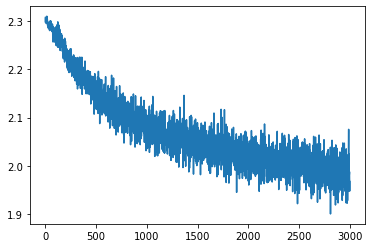

In [20]:
plt.plot(losses)